In [1]:
#####Nested Bayesian Tucker Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
type_n = 2
graph = 2
k1 = 12
k2 = 10
company = 5000
item = 3000
element = 250
Lambda1 = np.random.gamma(20.0, 1/0.2, company)
Lambda2 = np.random.gamma(25.0, 1/0.2, company)
pt1 = np.random.poisson(Lambda1, company)
pt2 = np.random.poisson(Lambda2, company)
N1 = np.sum(pt1); N2 = np.sum(pt2)
N = [N1, N2]
k_vec1 = np.array(np.repeat(1, k1), dtype="float32")
k_vec2 = np.array(np.repeat(1, k2), dtype="float32")

In [4]:
##IDとインデックスを作成
#IDの作成
company_id1 = np.repeat(np.arange(company), pt1)
company_id2 = np.repeat(np.arange(company), pt2)
pt_id1 = np.array(list(itertools.chain(*[np.array(range(pt1[i]), dtype="int") for i in range(company)])))
pt_id2 = np.array(list(itertools.chain(*[np.array(range(pt2[i]), dtype="int") for i in range(company)])))

#インデックスの設定
company_list1 = [i for i in range(company)]
company_list2 = [i for i in range(company)]
for i in range(company):
    company_list1[i] = np.array(np.where(company_id1==i)[0], dtype="int")
    company_list2[i] = np.array(np.where(company_id2==i)[0], dtype="int")

In [5]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [6]:
##itemとelementの割当を生成
#トピック割当を生成
topic = 25
theta_topic = np.random.dirichlet(np.repeat(0.3, topic), company)
phi_item = np.random.dirichlet(np.repeat(0.25, item), topic)
phi_element = np.random.dirichlet(np.repeat(0.25, element), topic)
z1 = np.array(rmnom(theta_topic[company_id1, ], N1, topic, np.arange(N1), 0), dtype="int16")
z21 = np.array(rmnom(theta_topic[company_id2, ], N2, topic, np.arange(N2), 0), dtype="int16")
z22 = np.array(rmnom(theta_topic[company_id2, ], N2, topic, np.arange(N2), 0), dtype="int16")

#多項分布からitemとelementを生成
item_id1 = np.zeros(N1, dtype="int16"); item_id21 = np.zeros(N2, dtype="int16"); item_id22 = np.zeros(N2, dtype="int16")
element_id1 = np.zeros(N1, dtype="int16"); element_id21 = np.zeros(N2, dtype="int16"); element_id22 = np.zeros(N2, dtype="int16")
for i in range(company):
    index1 = company_list1[i]; index2 = company_list2[i]
    item_id1[index1] = np.array(rmnom(phi_item[z1[index1, ], ], pt1[i], item, np.arange(pt1[i]), 0), dtype="int16")
    element_id1[index1] = np.array(rmnom(phi_element[z1[index1, ], ], pt1[i], element, np.arange(pt1[i]), 0), dtype="int16")
    item_id21[index2] = np.array(rmnom(phi_item[z21[index2, ], ], pt2[i], item, np.arange(pt2[i]), 0), dtype="int16")
    item_id22[index2] = np.array(rmnom(phi_item[z22[index2, ], ], pt2[i], item, np.arange(pt2[i]), 0), dtype="int16")
    element_id21[index2] = np.array(rmnom(phi_element[z21[index2, ], ], pt2[i], element, np.arange(pt2[i]), 0), dtype="int16")
    element_id22[index2] = np.array(rmnom(phi_element[z22[index2, ], ], pt2[i], element, np.arange(pt2[i]), 0), dtype="int16")
    
#itemとelementのインデックス
item_list1 = [i for i in range(item)]; item_list21 = [i for i in range(item)]; item_list22 = [i for i in range(item)]
item_n1 = np.repeat(0, item); item_n21 = np.repeat(0, item); item_n22 = np.repeat(0, item)
element_list1 = [i for i in range(element)]; element_list21 = [i for i in range(element)]; element_list22 = [i for i in range(element)]
element_n1 = np.repeat(0, element); element_n21 = np.repeat(0, element); element_n22 = np.repeat(0, element)
for i in range(item):
    item_list1[i] = np.array(np.where(item_id1==i)[0], dtype="int")
    item_list21[i] = np.array(np.where(item_id21==i)[0], dtype="int")
    item_list22[i] = np.array(np.where(item_id22==i)[0], dtype="int")
    item_n1[i] = item_list1[i].shape[0]
    item_n21[i] = item_list21[i].shape[0]
    item_n22[i] = item_list22[i].shape[0]
for i in range(element):
    element_list1[i] = np.array(np.where(element_id1==i)[0], dtype="int")
    element_list21[i] = np.array(np.where(element_id21==i)[0], dtype="int")
    element_list22[i] = np.array(np.where(element_id22==i)[0], dtype="int")
    element_n1[i] = element_list1[i].shape[0]
    element_n21[i] = element_list21[i].shape[0]
    element_n22[i] = element_list22[i].shape[0]

In [9]:
####応答変数を生成####
per_min = 100; per_max = 100
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #階層モデルの事前分布
    alpha1 = np.repeat(0.0, k1)
    alpha21 = np.repeat(0.0, k2)
    alpha22 = np.repeat(1.0, k2)
    Cov_v = np.diag(np.repeat(0.4, k1))
    Cov_i = np.diag(np.repeat(0.3, k2))
    Cov_e = np.diag(np.repeat(0.2, k2))
    Covt_v = Cov_v.copy(); Covt_i = Cov_i.copy(); Covt_e = Cov_e.copy()
    
    #モデルパラメータを生成
    Sigma = np.array([1.0])
    beta = np.array([-0.75, -0.75])
    theta_v = np.random.multivariate_normal(alpha1, Cov_v, company)
    theta_i = np.random.multivariate_normal(alpha21, Cov_i, item)
    theta_e = np.random.multivariate_normal(alpha22, Cov_e, element)
    omega1 = np.random.normal(0, 0.5, k1*k2).reshape(k1, k2)
    omega2 = np.random.normal(0, 0.3, k1*k2*k2).reshape(k1, k2, k2)
    betat = beta.copy()
    thetat_v = theta_v.copy(); thetat_i = theta_i.copy(); thetat_e = theta_e.copy()
    omegat1 = omega1.copy(); omegat2 = omega2.copy()

    #正規分布から応答変数を生成
    #タッカー分解の期待値
    joint_theta1 = theta_i[item_id21, ] * theta_e[element_id21, ]
    joint_theta2 = theta_i[item_id22, ] * theta_e[element_id22, ]
    uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
    uv2 = np.zeros((N2, k2))
    for j in range(k2):
        uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ] * joint_theta2[:, j][:, np.newaxis]
    uv2 = np.dot(uv2 * joint_theta1, k_vec2)
    mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

    #潜在効用から二値変数を生成
    U1 = np.random.normal(mu1, Sigma, N1)
    U2 = np.random.normal(mu2, Sigma, N2)
    y1 = (U1 >= 0)*1 + (U1 < 0)*0  ; y2 = (U2 >= 0)*1 + (U2 < 0)*0
    Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)

    #break条件
    if ((np.mean(y1) > 0.2) & (np.mean(y1) < 0.4) & (np.mean(y2) > 0.2) & (np.mean(y2) < 0.4) &
        (np.sum(U1 <= -7.5) < N1/per_min) & (np.sum(U1 > 7.5) < N1/per_max) & 
        (np.sum(U2 <= -7.5) < N2/per_min) & (np.sum(U2 > 7.5) < N2/per_max)):
            break

1
2


In [10]:
#応答変数をリストに格納
mu = [mu1, mu2]; mut = [mu1, mu2]
U = [U1, U2]; UT = [U1, U2]
y = [y1, y2]
Prob = [Prob1, Prob2]

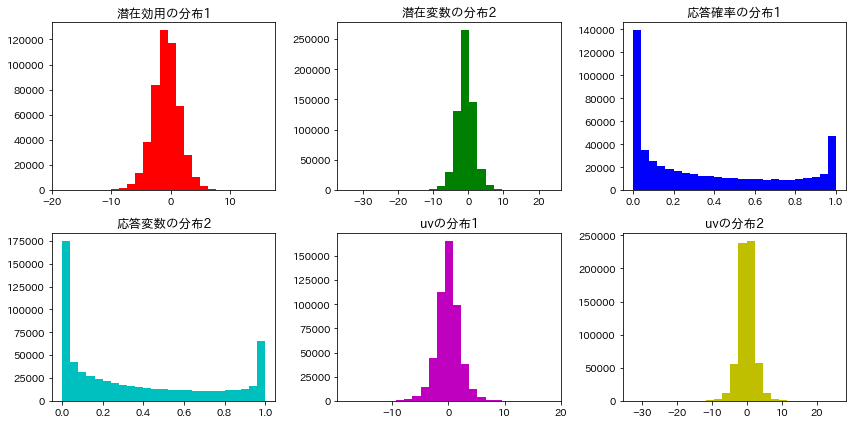

In [11]:
#潜在変数ごとのヒストグラム
dt = [U1, U2, Prob1, Prob2, uv1, uv2]
fig_range = np.append(np.array([np.min(U1), np.min(U2), 0, 0, np.min(uv1), np.min(uv2)]), 
                      np.array([np.max(U1), np.max(U2), 1.0, 1.0, np.max(uv1), np.max(uv2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布1", "潜在変数の分布2", "応答確率の分布1", "応答変数の分布2", "uvの分布1", "uvの分布2"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [12]:
####テストデータを生成####
##データの設定
division = 2
pt01 = np.random.poisson(Lambda1 / division, company)
pt02 = np.random.poisson(Lambda2 / division, company)
pt01[pt01 < 5] = 5; pt02[pt02 < 5] = 5
N01 = np.sum(pt01)
N02 = np.sum(pt02)

In [13]:
##IDとインデックスを作成
#IDの作成
company_id01 = np.repeat(np.arange(company), pt01)
company_id02 = np.repeat(np.arange(company), pt02)
pt_id01 = np.array(list(itertools.chain(*[np.array(range(pt01[i]), dtype="int") for i in range(company)])))
pt_id02 = np.array(list(itertools.chain(*[np.array(range(pt02[i]), dtype="int") for i in range(company)])))

#インデックスの設定
company_list01 = [i for i in range(company)]
company_list02 = [i for i in range(company)]
for i in range(company):
    company_list01[i] = np.array(np.where(company_id01==i)[0], dtype="int")
    company_list02[i] = np.array(np.where(company_id02==i)[0], dtype="int")

In [ ]:
##itemとelementの割当を生成
#トピック割当を生成
z1 = np.array(rmnom(theta_topic[company_id01, ], N01, topic, np.arange(N01), 0), dtype="int16")
z21 = np.array(rmnom(theta_topic[company_id02, ], N02, topic, np.arange(N02), 0), dtype="int16")
z22 = np.array(rmnom(theta_topic[company_id02, ], N02, topic, np.arange(N02), 0), dtype="int16")

#多項分布からitemとelementを生成
item_id01 = np.zeros(N01, dtype="int16"); item_id021 = np.zeros(N02, dtype="int16"); item_id022 = np.zeros(N02, dtype="int16")
element_id01 = np.zeros(N01, dtype="int16"); element_id021 = np.zeros(N02, dtype="int16"); element_id022 = np.zeros(N02, dtype="int16")
for i in range(company):
    index1 = company_list01[i]; index2 = company_list02[i]
    item_id01[index1] = np.array(rmnom(phi_item[z1[index1, ], ], pt01[i], item, np.arange(pt01[i]), 0), dtype="int16")
    element_id01[index1] = np.array(rmnom(phi_element[z1[index1, ], ], pt01[i], element, np.arange(pt01[i]), 0), dtype="int16")
    item_id021[index2] = np.array(rmnom(phi_item[z21[index2, ], ], pt02[i], item, np.arange(pt02[i]), 0), dtype="int16")
    item_id022[index2] = np.array(rmnom(phi_item[z22[index2, ], ], pt02[i], item, np.arange(pt02[i]), 0), dtype="int16")
    element_id021[index2] = np.array(rmnom(phi_element[z21[index2, ], ], pt02[i], element, np.arange(pt02[i]), 0), dtype="int16")
    element_id022[index2] = np.array(rmnom(phi_element[z22[index2, ], ], pt02[i], element, np.arange(pt02[i]), 0), dtype="int16")
    
#itemとelementのインデックス
item_list01 = [i for i in range(item)]; item_list021 = [i for i in range(item)]; item_list022 = [i for i in range(item)]
item_n01 = np.repeat(0, item); item_n021 = np.repeat(0, item); item_n022 = np.repeat(0, item)
element_list01 = [i for i in range(element)]; element_list021 = [i for i in range(element)]; element_list022 = [i for i in range(element)]
element_n01 = np.repeat(0, element); element_n021 = np.repeat(0, element); element_n022 = np.repeat(0, element)
for i in range(item):
    item_list01[i] = np.array(np.where(item_id01==i)[0], dtype="int")
    item_list021[i] = np.array(np.where(item_id021==i)[0], dtype="int")
    item_list022[i] = np.array(np.where(item_id022==i)[0], dtype="int")
    item_n01[i] = item_list01[i].shape[0]
    item_n021[i] = item_list021[i].shape[0]
    item_n022[i] = item_list022[i].shape[0]
for i in range(element):
    element_list01[i] = np.array(np.where(element_id01==i)[0], dtype="int")
    element_list021[i] = np.array(np.where(element_id021==i)[0], dtype="int")
    element_list022[i] = np.array(np.where(element_id022==i)[0], dtype="int")
    element_n01[i] = element_list01[i].shape[0]
    element_n021[i] = element_list021[i].shape[0]
    element_n022[i] = element_list022[i].shape[0]

In [ ]:
##応答変数を生成
#タッカー分解の期待値
joint_theta1 = theta_i[item_id021, ] * theta_e[element_id021, ]
joint_theta2 = theta_i[item_id022, ] * theta_e[element_id022, ]
uv1 = np.dot(np.dot(theta_v, omega1)[company_id01, ] * theta_i[item_id01, ] * theta_e[element_id01, ], k_vec2)
uv2 = np.zeros((N02, k2))
for j in range(k2):
    uv2 += np.dot(theta_v, omega2[:, :, j])[company_id02, ] * joint_theta2[:, j][:, np.newaxis]
uv2 = np.dot(uv2 * joint_theta1, k_vec2)
mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

#潜在効用から二値変数を生成
U01 = np.random.normal(mu1, Sigma, N01); UT01 = U01.copy()
U02 = np.random.normal(mu2, Sigma, N02); UT02 = U02.copy()
y01 = (U01 >= 0)*1 + (U01 < 0)*0  ; y02 = (U02 >= 0)*1 + (U02 < 0)*0
Prob01 = norm.cdf(mu1, 0, Sigma); Prob02 = norm.cdf(mu2, 0, Sigma)

In [ ]:
#応答変数をリストに格納
U0 = [U01, U02]; UT0 = [UT01, UT02]
y0 = [y01, y02]
Prob0 = [Prob01, Prob02]

In [ ]:
####Nested Bayesian Tucker Decompositionを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [ ]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [ ]:
##itemとelementのインデックスを作成
#インデックスの格納用配列
item_list21 = [i for i in range(item)]
item_list22 = [i for i in range(item)]
item_list23 = [i for i in range(item)]
element_list21 = [i for i in range(element)]
element_list22 = [i for i in range(element)]
element_list23 = [i for i in range(element)]

#インデックスを作成
flag = item_id21==item_id22
for i in range(item):
    item_list21[i] = np.array(np.where((flag==False) & (item_id21==i))[0], dtype="int")
    item_list22[i] = np.array(np.where((flag==False) & (item_id22==i))[0], dtype="int")
    item_list23[i] = np.array(np.where((flag==True) & (item_id21==i))[0], dtype="int")
flag = element_id21==element_id22
for i in range(element):
    element_list21[i] = np.array(np.where((flag==False) & (element_id21==i))[0], dtype="int")
    element_list22[i] = np.array(np.where((flag==False) & (element_id22==i))[0], dtype="int")
    element_list23[i] = np.array(np.where((flag==True) & (element_id21==i))[0], dtype="int")

In [ ]:
##事前分布の設定
#階層モデルの事前分布
alpha1 = np.array(np.repeat(0.0, k1), dtype="float32")
alpha21 = np.array(np.repeat(0.0, k2), dtype="float32")
alpha22 = np.array(np.repeat(1.0, k2), dtype="float32")
alpha3 = np.repeat(0.0, k1*k2)
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))
nu = 1
s01 = 0.1
v01 = 0.1

#モデルパラメータの事前分布
Cov = np.diag(np.repeat(100.0, k1*k2))
inv_Cov = np.linalg.inv(Cov)
tau = 100 
s02 = 1.0
v02 = 1.0

In [ ]:
##パラメータの真値
#階層モデルの分散の真値
Cov_v = np.array(Covt_v.copy(), dtype="float32")
Cov_i = np.array(Covt_i.copy(), dtype="float32")
Cov_e = np.array(Covt_e.copy(), dtype="float32")
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_i = np.linalg.inv(Cov_i)
inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの真値
Sigma = np.array([1.0], dtype="float32")
beta = np.array(betat, dtype="float32")
theta_v = np.array(thetat_v, dtype="float32")
theta_i = np.array(thetat_i, dtype="float32")
theta_e = np.array(thetat_e, dtype="float32")
omega1 = np.array(omegat1, dtype="float32")
omega2 = np.array(omegat2, dtype="float32")

#パラメータの設定
theta_item21 = theta_i[item_id21,]; theta_item22 = theta_i[item_id21, ]
theta_element21 = theta_e[element_id21, ]; theta_element22 = theta_e[element_id22, ]
joint_theta1 = theta_i[item_id1, ] * theta_e[element_id1, ]
joint_theta21 = theta_i[item_id21, ] * theta_e[element_id21, ]
joint_theta22 = theta_i[item_id22, ] * theta_e[element_id22, ]

#タッカー分解の期待値
uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
uv2 = np.zeros((N2, k2))
for j in range(k2):
    uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ] * joint_theta22[:, j][:, np.newaxis]
uv2 = np.dot(uv2 * joint_theta21, k_vec2)
mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

In [ ]:
##パラメータの初期値
#階層モデルの分散の初期値
Cov_v = np.array(np.diag(np.repeat(1.0, k1)), dtype="float32")
Cov_i = np.array(np.diag(np.repeat(1.0, k2)), dtype="float32")
Cov_e = np.array(np.diag(np.repeat(1.0, k2)), dtype="float32")
inv_Cov_v = np.linalg.inv(Cov_v)
inv_Cov_i = np.linalg.inv(Cov_i)
inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの初期値
Sigma = np.array([1.0], dtype="float32")
beta = np.array([-0.7, -0.7], dtype="float32")
theta_v = np.array(np.random.multivariate_normal(alpha1, np.diag(np.repeat(0.1, k1)), company), dtype="float32")
theta_i = np.array(np.random.multivariate_normal(alpha21, np.diag(np.repeat(0.1, k2)), item), dtype="float32")
theta_e = np.array(np.random.multivariate_normal(alpha22, np.diag(np.repeat(0.1, k2)), element), dtype="float32")
omega1 = np.array(np.random.normal(0, 0.1, k1*k2).reshape(k1, k2), dtype="float32")
omega2 = np.array(np.random.normal(0, 0.1, k1*k2*k2).reshape(k1, k2, k2), dtype="float32")

#パラメータの設定
theta_item21 = theta_i[item_id21,]; theta_item22 = theta_i[item_id22, ]
theta_element21 = theta_e[element_id21, ]; theta_element22 = theta_e[element_id22, ]
joint_theta1 = theta_i[item_id1, ] * theta_e[element_id1, ]
joint_theta21 = theta_i[item_id21, ] * theta_e[element_id21, ]
joint_theta22 = theta_i[item_id22, ] * theta_e[element_id22, ]

#タッカー分解の期待値
uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
uv2 = np.zeros((N2, k2))
for j in range(k2):
    uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ] * joint_theta22[:, j][:, np.newaxis]
uv2 = np.dot(uv2 * joint_theta21, k_vec2)
mu1 = beta[0] + uv1; mu2 = beta[1] + uv2

In [ ]:
##データの設定
#切断領域を定義
rho = 100.0
a = [j for j in range(graph)]; b = [j for j in range(graph)]
for j in range(graph):
    a[j] = np.array((1-y[j])*(-rho) + y[j]*0, dtype="float32")
    b[j] = np.array(y[j]*rho + (1-y[j])*0, dtype="float32")

#特徴行列の割当インデックス
allocation1 = np.repeat(np.arange(k2), k2)
allocation2 = np.tile(np.arange(k2), k2)
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k2), j).tolist() for j in range(k2)])

In [ ]:
##サンプリング結果の格納用配列
#階層モデルの格納用配列
COV_V = np.zeros((k1, k1, int(R/keep)), dtype="float32")
COV_I = np.zeros((k2, k2, int(R/keep)), dtype="float32")
COV_E = np.zeros((k2, k2, int(R/keep)), dtype="float32")

#モデルパラメータの格納用配列
BETA = np.zeros((int(R/keep), graph), dtype="float32")
THETA_V = np.zeros((company, k1, int(R/keep)), dtype="float32")
THETA_I = np.zeros((item, k2, int(R/keep)), dtype="float32")
THETA_E = np.zeros((element, k2, int(R/keep)), dtype="float32")
OMEGA1 = np.zeros((k1, k2, int(R/keep)), dtype="float32")
OMEGA2 = np.zeros((k1, k2, k2, int(R/keep)), dtype="float32")

In [ ]:
##対数尤度の基準値
#学習データに対する1パラメータモデルの対数尤度
Prob1 = np.mean(y1); Prob2 = np.mean(y2)
LLst1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
LLst2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
LLst = LLst1 + LLst2
print(np.round([LLst1, LLst2, LLst], 1))

#学習データに対する真値の対数尤度
joint_theta121 = thetat_i[item_id21, ] * thetat_e[element_id21, ]
joint_theta122 = thetat_i[item_id22, ] * thetat_e[element_id22, ]
uv11 = np.dot(np.dot(thetat_v, omegat1)[company_id1, ] * thetat_i[item_id1, ] * thetat_e[element_id1, ], k_vec2)
uv12 = np.zeros((N2, k2))
for j in range(k2):
    uv12 += np.dot(thetat_v, omegat2[:, :, j])[company_id2, ] * joint_theta122[:, j][:, np.newaxis]
uv12 = np.dot(uv12 * joint_theta121, k_vec2)
mu1 = betat[0] + uv11; mu2 = betat[1] + uv12
Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
LLbest1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
LLbest2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
LLbest = LLbest1 + LLbest2
print(np.round([LLbest1, LLbest2, LLbest], 1))

#学習データに対する1パラメータモデルの対数尤度
Prob1 = np.mean(y1); Prob2 = np.mean(y2)
LLst01 = np.sum(y01*np.log(Prob1) + (1-y01)*np.log(1-Prob1))
LLst02 = np.sum(y02*np.log(Prob2) + (1-y02)*np.log(1-Prob2))
LLst0 = LLst01 + LLst02
print(np.round([LLst01, LLst02, LLst0], 1))

#テストデータに対する真値の対数尤度
joint_theta021 = thetat_i[item_id021, ] * thetat_e[element_id021, ]
joint_theta022 = thetat_i[item_id022, ] * thetat_e[element_id022, ]
uv01 = np.dot(np.dot(thetat_v, omegat1)[company_id01, ] * thetat_i[item_id01, ] * thetat_e[element_id01, ], k_vec2)
uv02 = np.zeros((N02, k2))
for j in range(k2):
    uv02 += np.dot(thetat_v, omegat2[:, :, j])[company_id02, ] * joint_theta022[:, j][:, np.newaxis]
uv02 = np.dot(uv02 * joint_theta021, k_vec2)
mu1 = betat[0] + uv01; mu2 = betat[1] + uv02
Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
LLbest01 = np.sum(y01*np.log(Prob1) + (1-y01)*np.log(1-Prob1))
LLbest02 = np.sum(y02*np.log(Prob2) + (1-y02)*np.log(1-Prob2))
LLbest0 = LLbest01 + LLbest02
print(np.round([LLbest01, LLbest02, LLbest0], 1))

In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #タッカー分解の期待値
    uv1 = np.dot(np.dot(theta_v, omega1)[company_id1, ] * joint_theta1, k_vec2)
    uv2 = np.zeros((N2, k2))
    for j in range(k2):
        uv2 += np.dot(theta_v, omega2[:, :, j])[company_id2, ] * joint_theta22[:, j][:, np.newaxis]
    uv2 = np.dot(uv2 * joint_theta21, k_vec2)
    uv = [uv1, uv2]

    #潜在変数を生成
    mu = [j for j in range(graph)]
    U = [j for j in range(graph)]
    for j in range(graph):
        mu[j] = beta[j] + uv[j]
        U[j] = np.array(rtnorm(mu[j], Sigma, a[j], b[j], N[j]), dtype="float32")

    ##モデル期待値のパラメータをサンプリング
    for j in range(graph):
        #モデル誤差を定義
        er_y = U[j] - uv[j]

        #正規分布から期待値をサンプリング
        weights = tau / (Sigma/N[j] + tau)
        mu_par = weights * np.mean(er_y)
        beta[j] = np.random.normal(mu_par, weights*Sigma/N[j], 1)


    ##company特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = [U[j] - beta[j] for j in range(graph)]

    #推定対象のパラメータを期待値から除く
    x1 = np.dot(joint_theta1, omega1.T)
    x2 = np.zeros((N2, k1), dtype="float32")
    for j in range(k2):
        x2 += np.dot(joint_theta21 * joint_theta22[:, j][:, np.newaxis], omega2[:, :, j].T)

    for i in range(company):
        #データの定義
        index1 = company_list1[i]; index2 = company_list2[i]
        u = np.append(er_y[0][index1], er_y[1][index2])
        x = np.vstack((x1[index1, ], x2[index2, ]))

        #多変量正規分布から事後分布をサンプリング
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_v
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov_v, alpha1))
        theta_v[i, ] = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1)


    ##item特徴ベクトルをサンプリング
    #推定対象のパラメータを期待値から除く
    x1 = np.dot(theta_v, omega1)[company_id1, ] * theta_e[element_id1, ]
    x21 = np.zeros((N2, k2), dtype="float32"); x22 = np.zeros((N2, k2), dtype="float32")
    AR = [j for j in range(k2)]
    for j in range(k2):
        AR[j] = np.dot(theta_v, omega2[:, :, j])[company_id2, ]
        x21 += AR[j]  * joint_theta22[:, j][:, np.newaxis]
        x22[:, j] = np.dot(AR[j] * joint_theta21 * theta_element22[:, j][:, np.newaxis], k_vec2)
    x21 = x21 * theta_element21

    for i in range(item):
        #データの定義
        index1 = item_list1[i]
        index21 = item_list21[i]; index22 = item_list22[i]; index23 = item_list23[i]
        x = np.vstack((x1[index1, ], x21[index21, ], x22[index22, ], x21[index23, ] + x22[index23, ]))
        u = np.hstack((er_y[0][index1], er_y[1][index21], er_y[1][index22], 2*er_y[1][index23]))

        #多変量正規分布から事後分布をサンプリング
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_i
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov_i, alpha21))
        theta_i[i, ] = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1)

    #パラメータを更新
    theta_item21 = theta_i[item_id21,]; theta_item22 = theta_i[item_id22, ]
    joint_theta21 = theta_item21 * theta_element21
    joint_theta22 = theta_item22 * theta_element22


    ##element特徴ベクトルをサンプリング
    #推定対象のパラメータを期待値から除く
    x1 = np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ]
    x21 = np.zeros((N2, k2), dtype="float32"); x22 = np.zeros((N2, k2), dtype="float32")
    for j in range(k2):
        x21 += AR[j] * joint_theta22[:, j][:, np.newaxis]
        x22[:, j] = np.dot(AR[j] * joint_theta21 * theta_item22[:, j][:, np.newaxis], k_vec2)
    x21 = x21 * theta_item21

    for i in range(element):
        #データの定義
        index1 = element_list1[i]
        index21 = element_list21[i]; index22 = element_list22[i]; index23 = element_list23[i]
        x = np.vstack((x1[index1, ], x21[index21, ], x22[index22, ], x21[index23, ] + x22[index23, ]))
        u = np.hstack((er_y[0][index1], er_y[1][index21], er_y[1][index22], 2*er_y[1][index23]))

        #多変量正規分布から事後分布をサンプリング
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_e
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov_e, alpha22))
        theta_e[i, ] = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1)

    #パラメータを更新
    theta_element21 = theta_e[element_id21,]; theta_element22 = theta_e[element_id22, ]
    joint_theta1 = theta_i[item_id1, ] * theta_e[element_id1, ]
    joint_theta21 = theta_item21 * theta_element21
    joint_theta22 = theta_item22 * theta_element22


    ##双線形回帰行列をサンプリング
    #データの定義
    u = er_y[0]
    x = theta_v[:, allocation_u][company_id1, ] * joint_theta1[:, allocation_v]

    #多変量正規分布から事後分布をサンプリング
    xy = np.dot(x.T, u)
    xxv = np.dot(x.T, x) + inv_Cov
    inv_xxv = np.linalg.inv(xxv)
    omega_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha3))
    omega1 = np.array(np.random.multivariate_normal(omega_mu, Sigma*inv_xxv, 1).reshape(k1, k2), dtype="float32")


    ##コアテンソルをサンプリング
    #タッカー分解の期待値を展開
    uv_deploy = np.zeros((N2, k2), dtype="float32")
    for j in range(k2):
        uv_deploy[:, j] = np.dot(AR[j] * joint_theta21 * joint_theta22[:, j][:, np.newaxis], k_vec2)
    theta_deploy = theta_v[:, allocation_u][company_id2, ] * joint_theta21[:, allocation_v]

    #多変量正規分布から事後分布をサンプリング
    for j in range(k2):
        er_y = U[1] - beta[1] - np.dot(uv_deploy[:, allocation_omega[j, ]], np.repeat(1, k2-1))   #モデル誤差
        x = theta_deploy * joint_theta22[:, j][:, np.newaxis]
        xy = np.dot(x.T, er_y)
        xxv = np.dot(x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        omega_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha3))
        omega2[:, :, j] = np.random.multivariate_normal(omega_mu, Sigma*inv_xxv, 1).reshape(k1, k2)
        uv_deploy[:, j] = np.dot(np.dot(theta_v, omega2[:, :, j])[company_id2, ] * 
                                 joint_theta21 * joint_theta22[:, j][:, np.newaxis], k_vec2)


    ##階層モデルのパラメータをサンプリング
    #company特徴ベクトルの分散をサンプリング
    er = theta_v - np.mean(theta_v, axis=0)
    IW_R = np.dot(er.T, er) + V1
    Sn = company + nu
    Cov_v = np.array(np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1))), dtype="float32")
    inv_Cov_v = np.linalg.inv(Cov_v)

    #item特徴ベクトルの分散をサンプリング
    er = theta_i - np.mean(theta_i, axis=0)
    IW_R = np.dot(er.T, er) + V2
    Sn = item + nu
    Cov_i = np.array(np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1))), dtype="float32")
    inv_Cov_i = np.linalg.inv(Cov_i)

    #element特徴ベクトルの分散をサンプリング
    er = theta_e.reshape(-1) - np.mean(theta_e)
    s1 = np.dot(er.T, er) + s01
    v1 = k2*element + v01
    Cov_e = np.array(np.diag(np.repeat(1/np.random.gamma(v1/2, 1/(s1/2), 1), k2)), dtype="float32")
    inv_Cov_e = np.linalg.inv(Cov_e)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #サンプリング結果の格納
        mkeep = int(rp/keep)
        COV_V[:, :, mkeep] = Cov_v
        COV_I[:, :, mkeep] = Cov_i
        COV_E[:, :, mkeep] = Cov_e
        BETA[mkeep, ] = beta
        THETA_V[:, :, mkeep] = theta_v
        THETA_I[:, :, mkeep] = theta_i
        THETA_E[:, :, mkeep] = theta_e
        OMEGA1[:, :, mkeep] = omega1
        OMEGA2[:, :, :, mkeep] = omega2

    #サンプリング結果の表示
    if rp%disp==0:
        #学習データに対する対数尤度を更新
        mu1 = beta[0] + np.dot(np.dot(theta_v, omega1)[company_id1, ] * theta_i[item_id1, ] * theta_e[element_id1, ], k_vec2)
        mu2 = beta[1] + np.dot(uv_deploy, k_vec2)
        Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
        Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
        Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
        LL1 = np.sum(y1*np.log(Prob1) + (1-y1)*np.log(1-Prob1))
        LL2 = np.sum(y2*np.log(Prob2) + (1-y2)*np.log(1-Prob2))
        LL = LL1 + LL2

        #テストデータに対する対数尤度を更新
        joint_theta021 = theta_i[item_id021, ] * theta_e[element_id021, ]
        joint_theta022 = theta_i[item_id022, ] * theta_e[element_id022, ]
        uv01 = np.dot(np.dot(theta_v, omega1)[company_id01, ] * theta_i[item_id01, ] * theta_e[element_id01, ], k_vec2)
        uv02 = np.zeros((N02, k2))
        for j in range(k2):
            uv02 += np.dot(theta_v, omega2[:, :, j])[company_id02, ] * joint_theta022[:, j][:, np.newaxis]
        uv02 = np.dot(uv02 * joint_theta021, k_vec2)
        mu1 = beta[0] + uv01; mu2 = beta[1] + uv02
        Prob1 = norm.cdf(mu1, 0, Sigma); Prob2 = norm.cdf(mu2, 0, Sigma)
        Prob1[Prob1==1.0] = 0.9999999999; Prob1[Prob1==0] = np.power(10.0, -100)
        Prob2[Prob2==1.0] = 0.9999999999; Prob2[Prob2==0] = np.power(10.0, -100)
        LL01 = np.sum(y01*np.log(Prob1) + (1-y01)*np.log(1-Prob1))
        LL02 = np.sum(y02*np.log(Prob2) + (1-y02)*np.log(1-Prob2))
        LL0 = LL01 + LL02

        #サンプリング結果の表示
        print(rp)
        print(np.round([LL1, LL2, LL, LLbest1, LLbest2, LLbest], 1))
        print(np.round([LL01, LL02, LL0, LLbest01, LLbest02, LLbest0], 1))